## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [50]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [51]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [52]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [53]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [54]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [55]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    object 
 13  home.dest  745 non-null    object 
 14  title      1309 non-null   object 
dtypes: float64(2), int64(4), object(9)
memory usage: 153.5+ KB


In [57]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [58]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [59]:
target = 'survived'

In [60]:
vars_cat = [var for var in data.columns if data[var].dtype == 'O']

vars_num = [var for var in data.columns if var not in vars_cat and var != 'survived']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


In [61]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [62]:
vars_num

['pclass', 'age', 'sibsp', 'parch', 'fare']

### Find missing values in variables

In [63]:
#identify nulls
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

#determine percentage of missing values expressed as decimals
# then display the result ordered by % of missing data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

cabin       0.774637
age         0.200917
embarked    0.001528
fare        0.000764
dtype: float64

In [64]:
# first in numerical variables
num_na = [var for var in vars_num if var in vars_with_na]
print('Number of numerical variables with na:', len(num_na))

Number of numerical variables with na: 2


In [65]:
# now in categorical variables

cat_na = [var for var in vars_cat if var in vars_with_na]
print('Number of numerical variables with na: ', len(cat_na))

Number of numerical variables with na:  2


### Determine cardinality of categorical variables

In [66]:
print('Number of categorical variables', len(vars_cat))

Number of categorical variables 4


In [67]:
data[vars_cat].head()

,sex,cabin,embarked,title
0,female,B5,S,Miss
1,male,C22,S,Master
2,female,C22,S,Miss
3,male,C22,S,Mr
4,female,C22,S,Mrs


<AxesSubplot:>

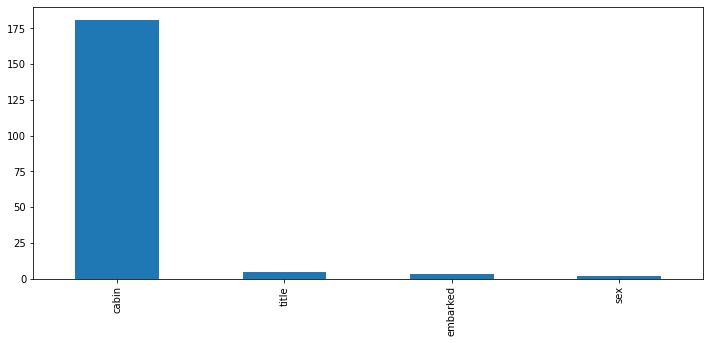

In [68]:
# count unique cats with pandas, ad plot them 
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [69]:
# map the variables

# sex map
sex_map = {'female': 0, 'male':1}

data['sex'] = data['sex'].map(sex_map)

In [70]:
#sanity
data.sex.value_counts()

1    843
0    466
Name: sex, dtype: int64

In [71]:
data.embarked.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [72]:
# embarked map
embarked_map = {'S':0, 'C':1, 'Q':2}

data['embarked'] = data['embarked'].map(embarked_map)

In [73]:
data.title.unique()

array(['Miss', 'Master', 'Mr', 'Mrs', 'Other'], dtype=object)

In [74]:
# title map
title_map = {'Miss':0, 'Master':1, 'Mr':2, 'Mrs':3, 'Other':4}

data['title'] = data['title'].map(title_map)

In [75]:
data[vars_cat].head()

,sex,cabin,embarked,title
0,0,B5,0.0,0
1,1,C22,0.0,1
2,0,C22,0.0,0
3,1,C22,0.0,2
4,0,C22,0.0,3


In [76]:
data

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,0,29.0000,0,0,211.3375,B5,0.0,0
1,1,1,1,0.9167,1,2,151.5500,C22,0.0,1
2,1,0,0,2.0000,1,2,151.5500,C22,0.0,0
3,1,0,1,30.0000,1,2,151.5500,C22,0.0,2
4,1,0,0,25.0000,1,2,151.5500,C22,0.0,3
...,...,...,...,...,...,...,...,...,...,...
1304,3,0,0,14.5000,1,0,14.4542,NaN,1.0,0
1305,3,0,0,NaN,1,0,14.4542,NaN,1.0,0
1306,3,0,1,26.5000,0,0,7.2250,NaN,1.0,2
1307,3,0,1,27.0000,0,0,7.2250,NaN,1.0,2


### Determine the distribution of numerical variables

In [77]:
print('Number of numerical variables ', len(vars_num))

Number of numerical variables  5


In [78]:
data[vars_num].head()

,pclass,age,sibsp,parch,fare
0,1,29.0000,0,0,211.3375
1,1,0.9167,1,2,151.5500
2,1,2.0000,1,2,151.5500
3,1,30.0000,1,2,151.5500
4,1,25.0000,1,2,151.5500


In [79]:
import seaborn as sns

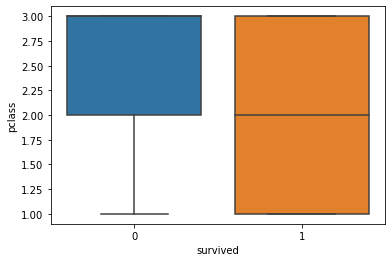

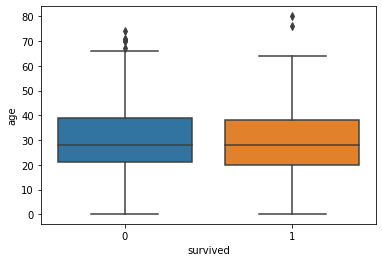

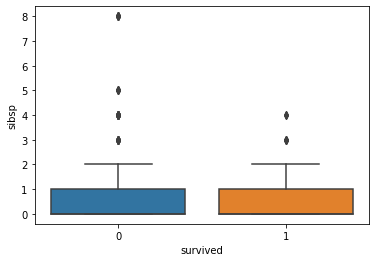

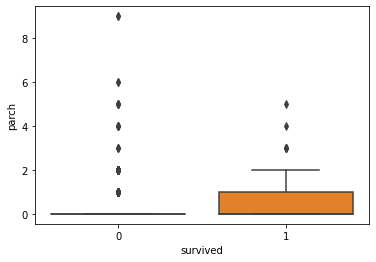

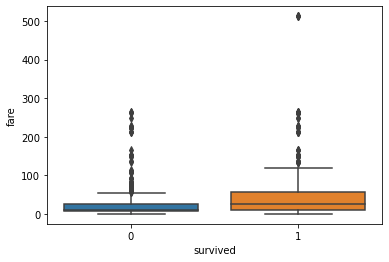

In [80]:
# discrete variables 
for var in data[vars_num]:
    sns.boxplot(y=var, x='survived', data=data)
    plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [82]:
X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]

In [83]:
X_train['cabin']

1118    NaN
44        E
1072    NaN
1130    NaN
574     NaN
       ... 
763     NaN
835     NaN
1216    NaN
559     NaN
684     NaN
Name: cabin, Length: 1047, dtype: object

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [84]:
vars_num, len(vars_num)

(['pclass', 'age', 'sibsp', 'parch', 'fare'], 5)

In [85]:
num_vars = [var for var in vars_num if X_train[var].isnull().sum() > 0]

X_train[num_vars].isnull().mean()

age     0.196753
fare    0.000955
dtype: float64

In [86]:
for var in num_vars:
    
    mean_val = X_train[var].mean()
    
    print(var, mean_val)
    
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

X_train[num_vars].isnull().sum()

age 30.05182318668252
fare 33.74475745697894


age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [87]:
X_train[cat_na].isnull().mean()

cabin       0.766953
embarked    0.001910
dtype: float64

In [88]:
X_train[cat_na] = X_train[cat_na].fillna('Missing')

In [89]:
X_test[cat_na] = X_test[cat_na].fillna('Missing')

In [90]:
X_train.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_na      0
fare_na     0
dtype: int64

In [91]:
X_test.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_na      0
fare_na     0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [92]:
qual_vars = X_train[cat_na]

len(vars_cat)

4

In [93]:
def find_frequent_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)[var].count()/len(df)
    
    return tmp[tmp > rare_perc].index

In [94]:
for var in qual_vars.columns:
    
    #find the frequent cats
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    print(var, frequent_ls)
    print()    

cabin Index(['A', 'B', 'C', 'D', 'E', 'F', 'Missing'], dtype='object', name='cabin')

embarked Index([0.0, 1.0, 2.0], dtype='object', name='embarked')



### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [95]:
def replace_cats(train, test, y_train, var, target):
    tmp = pd.concat([X_train, y_train], axis=1)
    
    #order the cats in a var form that goes from lowest ot highest
    orderd_labels = tmp.groupby([var])[target].mean().sort_values().index
    
    ordinal_label = {k: i for i, k in enumerate(orderd_labels, 0)}
    
    print(var, ordinal_label)
    print()
    
    #use dictionary to replace the cat strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [96]:
for var in vars_cat:
    replace_cats(X_train, X_test, y_train, var, 'survived')

sex {1: 0, 0: 1}

cabin {'T': 0, 'Missing': 1, 'A': 2, 'G': 3, 'F': 4, 'C': 5, 'D': 6, 'E': 7, 'B': 8}

embarked {0.0: 0, 2.0: 1, 1.0: 2, 'Missing': 3}

title {2: 0, 4: 1, 1: 2, 0: 3, 3: 4}



In [97]:
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [98]:
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

### Scale the variables

- Use the standard scaler from Scikit-learn

In [99]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [100]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
0,0.835808,-0.761042,-0.403163,-0.478911,-0.455423,-0.505177,-0.507443,-0.606358,-0.820909,-0.494921,-0.03092
1,-1.542157,1.313987,0.873724,-0.478911,-0.455423,1.971329,2.259709,1.868716,0.996199,-0.494921,-0.03092
2,0.835808,-0.761042,0.000000,-0.478911,-0.455423,-0.508928,-0.507443,0.631179,-0.820909,2.020526,-0.03092
3,0.835808,1.313987,-0.961801,-0.478911,-0.455423,-0.508112,-0.507443,-0.606358,0.996199,-0.494921,-0.03092
4,-0.353174,-0.761042,-0.083941,0.434422,-0.455423,-0.249358,-0.507443,-0.606358,-0.820909,-0.494921,-0.03092


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [117]:
clf = LogisticRegression(random_state=0, C=0.0005)

# train

clf.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [118]:
pred = clf.predict(X_train)

print('train accuracy score: {}'.format(accuracy_score(pred, y_train)))

train accuracy score: 0.6934097421203438


In [122]:
# make predictions for test set
class_ = clf.predict(X_train)
pred = clf.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = clf.predict(X_test)
pred = clf.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8425425038639877
train accuracy: 0.6934097421203438

test roc-auc: 0.8324999999999999
test accuracy: 0.6870229007633588



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**